## This notebook is to create future river forcing from three components: CLM, HF, and time-varying delta 
* how each component was made, please see **"create_45_rivers_forcing_01.ipynb"**

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from lo_tools import Lfun
Ldir = Lfun.Lstart()

### 1. Read the historical climatology (CLM) (1993-2022)



In [2]:
# define path to read files from
in_dir = Ldir['LOo'] / 'forcing' / 'cas2k' / 'river'
# read the Climatology (day of year)
ds = xr.open_dataset(f'{in_dir}/climatology/river_flow_CLM.nc')
# read the historical time-series daily forcing (1993-2022) as well 
hist = xr.open_dataset(f'{in_dir}/river_historical_1993-2022.nc')

In [3]:
# define path to save figures
fig_dir = Ldir['LOo'] / 'forcing' / 'cas2k' / 'river' /'plot'
Lfun.make_dir(fig_dir)

### 2. Read time-series High Frequency river forcing component (HF)

In [4]:
dt = xr.open_dataset(f'{in_dir}/climatology/river_flow_high_freq.nc')

### 3. Get the time-varying delta
* use the time series of percentage change × (CLM_1993-2022)

#### 3.1 calculate the delta

In [5]:
# CLM only has 366 day of year, broadcast the CLM for the whole time period, 
CLM_1993_2022 = ds['river_transport'].sel(dayofyear=dt['river_time'].dt.dayofyear)
CLM_1993_2022 = CLM_1993_2022.rename("river_clm")
HF_1993_2022 = dt['river_hf']

In [6]:
# read daily delta_percent_change from GFDL ESM4.0
percent = xr.open_dataset(f'{in_dir}/climatology/river_flow_percent_change_daily.nc')
percent = percent.rename({'time': 'river_time'})

In [7]:
start = percent['river_time'][0].dt.year.values
end = percent['river_time'][-1].dt.year.values
num_years = end - start + 1  # Total years to extend
CLM = CLM_1993_2022

In [8]:
CLM_extended = xr.concat([CLM] * (num_years // 30 + 1), dim="river_time").isel(river_time=slice(0, len(percent['river_time'])))
# replace the time for future period
CLM_extended = CLM_extended.assign_coords(river_time=percent['river_time'])

In [9]:
# calculate the time-varing delta
delta = percent['percent_change']*0.01 * CLM_extended 

In [10]:
delta =delta.drop_vars('dayofyear')

#### 3.2 calculate the future forcing

In [11]:
SUM = (CLM_1993_2022 + HF_1993_2022)

In [12]:
SUM_extended = xr.concat([SUM] * (num_years // 30 + 1), dim="river_time").isel(river_time=slice(0, len(percent['river_time'])))
SUM_extended = SUM_extended.assign_coords(river_time=percent['river_time'])
SUM_extended = SUM_extended.drop_vars('dayofyear')
# replace the time using future time-series 

In [13]:
FUT_2023_2100 = SUM_extended + delta

In [14]:

FUT_2023_2100 = FUT_2023_2100.to_dataset(name="future_flow")
SUM_extended = SUM_extended.to_dataset(name="clm_hf_flow")
future = xr.merge([FUT_2023_2100, SUM_extended])

#### put a cap on the future time series, if the baseflow is overshooting to the baseline

In [15]:
# when overshooting the baseline 0, reset to the corresponding CLM+HF
num_river = np.size(future.river)
for i in np.arange(1,num_river+1):    
    mean_future = np.mean(future['future_flow'].sel(river =i).values)     
    mask1 = (mean_future > 0) & (future['future_flow'].sel(river=i) < 0)
    mask2 = (mean_future < 0) & (future['future_flow'].sel(river=i) > 0)
    # Replace values where mask1 is True
    future['future_flow'].loc[dict(river=i)] = xr.where(mask1 | mask2, future['clm_hf_flow'].sel(river=i), future['future_flow'].sel(river=i))
    

In [16]:
# rename the variables name 

FUTURE = future.rename({
               'future_flow': 'river_transport',
                'clm_hf_flow': 'river_direction',
                        })

FUTURE['river_transport'].attrs['long_name'] = hist['river_transport'].attrs['long_name']
FUTURE['river_transport'].attrs['units'] = hist['river_transport'].attrs['units']

FUTURE['river_direction'].attrs['long_name'] = hist['river_direction'].attrs['long_name']
FUTURE['river_time'].attrs['long_name'] = hist['river_time'].attrs['long_name']


In [17]:
# Extract river_direction (1D array along river)
river_direction_hist = hist['river_direction'].isel(river_time=0)   # Take first time step since values are the same over time
# Broadcast to match future['river_time']
river_direction_future = river_direction_hist.expand_dims(dim='river_time').broadcast_like(FUTURE['river_direction'])

# **Fill NaNs by repeating values along river_time**
river_direction_future = river_direction_future.ffill(dim='river_time')  # Forward fill to copy values
# Replace clm_hf_flow in future with river_direction
FUTURE['river_direction'] = river_direction_future


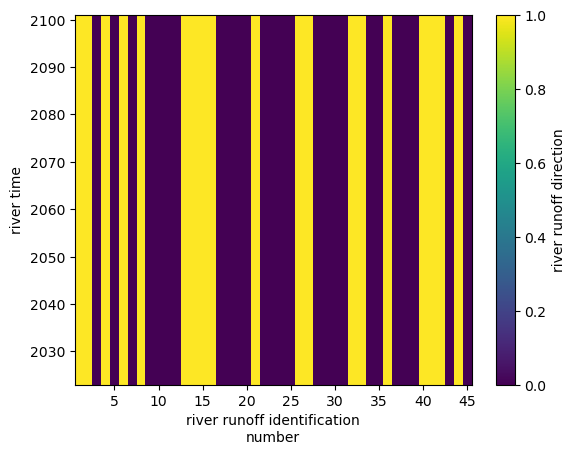

In [18]:
FUTURE['river_direction'].plot()

In [19]:
# save it netcdf file
FUTURE.to_netcdf(f'{in_dir}/river_future_2023-2100.nc')

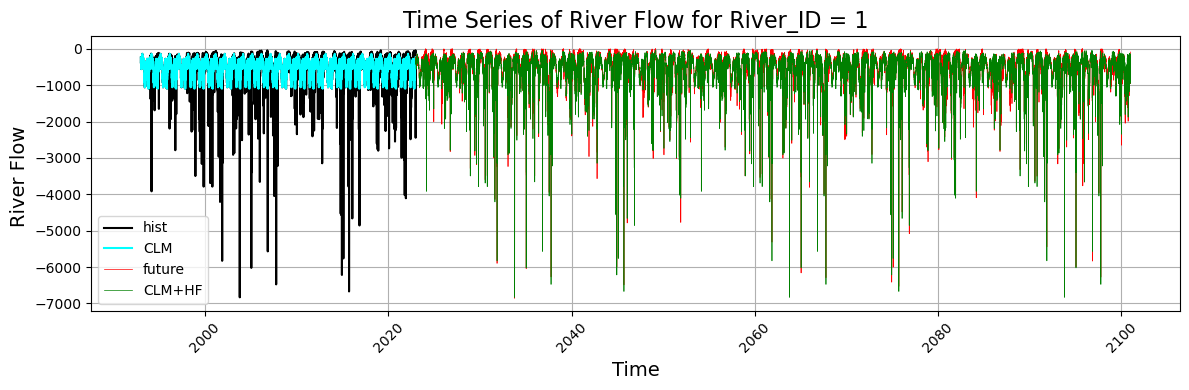

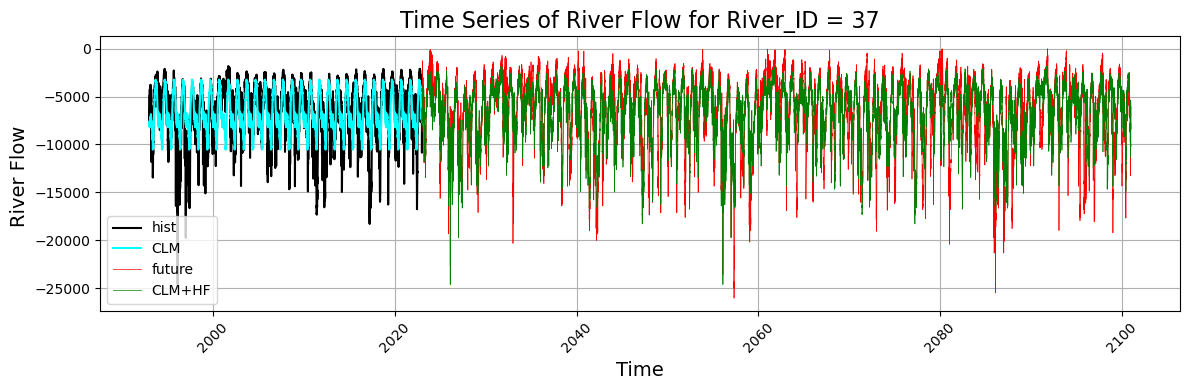

In [20]:
# Plot the historical + future change over time
for i in np.arange(1,num_river+1):
    # print(i)
    plt.figure(figsize=(12, 4))
    plt.plot(hist.river_time.values, hist['river_transport'].sel(river =i).values, marker='o', markersize=0,  color='k',linestyle= '-', label='hist')
    # plt.plot(sum.time.values, sum.sel(river =i), marker='o',  markersize=0, color='gray',linestyle= '-', label='CLM+HF')    
    # plt.plot(HF_1993_2022.river_time.values, HF_1993_2022.sel(river =i), marker='.', markersize=0, color='pink',linestyle= '-', label='HF')
    plt.plot(CLM_1993_2022.river_time.values, CLM_1993_2022.sel(river =i), marker='.', markersize=0, color='cyan',linestyle= '-', label='CLM')

    plt.plot(FUTURE.river_time.values, FUTURE['river_transport'].sel(river =i), marker='o', markersize=0, color='red', linestyle= '-', linewidth=0.5, label='future')
    plt.plot(SUM_extended.river_time.values, SUM_extended['clm_hf_flow'].sel(river =i), marker='o', markersize=0, color='green', linestyle= '-', linewidth=0.5, label='CLM+HF')
    # Add labels and title
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('River Flow ', fontsize=14)
    plt.title(f'Time Series of River Flow for River_ID = {i}', fontsize=16)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.tight_layout()
    # ffn = f"{fig_dir}/future_river_forcing_at_River_ID={i}.png"
    # plt.savefig(ffn)
    if i == 1 or i == 37:
        plt.show() # Show the plot  
    else:
        plt.close()
